In [43]:
import math
from graphviz import Digraph
import torch
import random

In [95]:
# backprop
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out        

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * (-1)
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only support int/float powers'
        out = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out
    
    def __relu__(self):
        out = Value(0 if self.data<0 else self.data, (self,), 'ReLU')
        
        def _backward():
            self.grad += out.grad * (self.data > 0)
        out._backward = _backward
        return out
    
    def tanh(self):
        x = math.exp(self.data*2)
        out = Value((x-1) / (x+1), (self,), 'Tanh')
        
        def _backward():
            self.grad += out.grad * (1-out.data**2)
        out._backward = _backward
        return out
    
    def exp(self):
        out = Value(math.exp(self.data), (self,), 'exp')
        
        def _backward():
            self.grad  += out.grad * out.data
        out._backward = _backward
        return out
    
    def __radd__(self, other): # other + self
        return self + other
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
                #print(topo)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    def __repr__(self):
        return f'Value(data={self.data}|label={self.label})'        
            

In [45]:
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
        # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

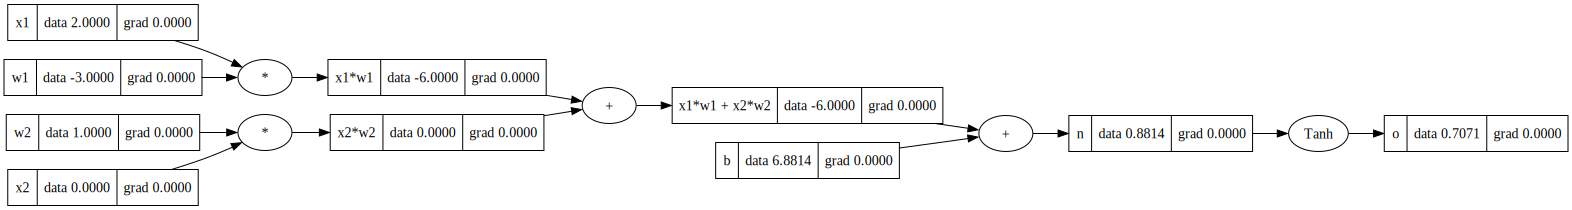

In [46]:
# Value for one layer
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'
o = n.tanh()
o.label = 'o'
draw_dot(o)

In [47]:
o.backward()

[Value(data=0.0|label=x2)]
[Value(data=0.0|label=x2), Value(data=1.0|label=w2)]
[Value(data=0.0|label=x2), Value(data=1.0|label=w2), Value(data=0.0|label=x2*w2)]
[Value(data=0.0|label=x2), Value(data=1.0|label=w2), Value(data=0.0|label=x2*w2), Value(data=2.0|label=x1)]
[Value(data=0.0|label=x2), Value(data=1.0|label=w2), Value(data=0.0|label=x2*w2), Value(data=2.0|label=x1), Value(data=-3.0|label=w1)]
[Value(data=0.0|label=x2), Value(data=1.0|label=w2), Value(data=0.0|label=x2*w2), Value(data=2.0|label=x1), Value(data=-3.0|label=w1), Value(data=-6.0|label=x1*w1)]
[Value(data=0.0|label=x2), Value(data=1.0|label=w2), Value(data=0.0|label=x2*w2), Value(data=2.0|label=x1), Value(data=-3.0|label=w1), Value(data=-6.0|label=x1*w1), Value(data=-6.0|label=x1*w1 + x2*w2)]
[Value(data=0.0|label=x2), Value(data=1.0|label=w2), Value(data=0.0|label=x2*w2), Value(data=2.0|label=x1), Value(data=-3.0|label=w1), Value(data=-6.0|label=x1*w1), Value(data=-6.0|label=x1*w1 + x2*w2), Value(data=6.88137358701

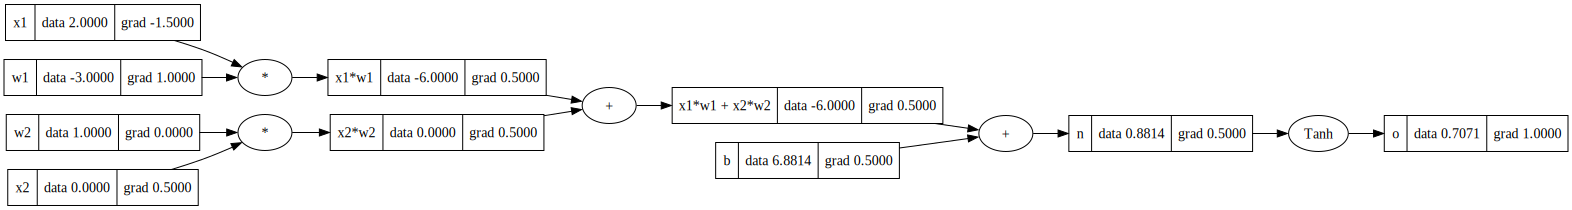

In [48]:
draw_dot(o)

In [49]:
# torch for one layer
x1 = torch.Tensor([2.0]).double()                
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  
b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [90]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [91]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.8898912733210788|label=)

In [92]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [118]:
for k in range(20):
  
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
  
    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad
  
    print(k, loss.data)


0 0.0007594469103813445
1 0.0007575012979952531
2 0.0007555653244910895
3 0.000753638919273639
4 0.0007517220124309719
5 0.0007498145347261977
6 0.0007479164175893699
7 0.000746027593109509
8 0.000744147994026765
9 0.0007422775537246156
10 0.0007404162062222581
11 0.0007385638861670885
12 0.0007367205288272122
13 0.0007348860700841842
14 0.0007330604464257688
15 0.0007312435949388163
16 0.0007294354533022311
17 0.0007276359597800837
18 0.0007258450532147585
19 0.0007240626730202528


In [119]:
ypred

[Value(data=0.992055854044435|label=),
 Value(data=-0.9925008424414191|label=),
 Value(data=-0.981698852819421|label=),
 Value(data=0.9835749013444881|label=)]

In [120]:
ys

[1.0, -1.0, -1.0, 1.0]